# Problem Defenition

Data on human activity during workout sessions are acquired using multiple devices attached to human body and dumbbells. The goal is to build a model to predict the quality of performance when using dumbbells. 

More infomation on the provided data is available [Here](http://web.archive.org/web/20161224072740/http:/groupware.les.inf.puc-rio.br/har).

Wearable devices provide inforamtion on the movements and accelaration of waist, wrist, forearm and dumbbell. The quality of executation is then alphabetically labelled as following 

Class A. exactly according to the specification
Class B. throwing the elbows to the front
Class C. lifting the dumbbell only halfway
Class D. lowering the dumbbell only halfway
Class E. throwing the hips to the front

## Loaing data

We use R packages ggplot2 for plotting and caret for implementing our model.

In [4]:
library(ggplot2)
library(caret)


Training <- read.csv(file="pml-training.csv", header=TRUE, sep=",")
Testing  <- read.csv(file="pml-testing.csv" , header=TRUE, sep=",")

dim(Training)
dim(Testing)

[1] 19622   160

[1]  20 160

## Slicing the Training Data

In order to be able to peroform some out-of-training evaluation, we only use 70% of our training data for training our model and leave out the rest for cross validation.

We perform the best model on the Testing data at the end. 

In [5]:
inTrain <- createDataPartition(y=Training$classe, p=0.7, list=FALSE)
training <- Training[inTrain,]
crossvalidation <- Training[-inTrain,]

## Checking out what we've got

A quick investigation using Open Office excell shows that there are many columns that are either empy or filled with "NA".
These columns are also missing in the Test data we have laoded. Therefore there is no point to use these columsn for training our model. 
Therefore we refine our data sets to only contain the relevant healthy data points. 

In [8]:
summary(training$classe)

print("Dimension of Training Set: ") ; dim(training)
print("Dimension of Cross Validation Set: ") ; dim(crossvalidation)

all_features = names(training)
for (i in seq_along(all_features)) {
    
    cat(sprintf("Quiz #%d \t \"%s\"\n", i, all_features[i]))
    
} 

A    B    C    D    E 
3906 2658 2396 2252 2525

[1] "Dimension of Training Set: "


[1] 13737   160

[1] "Dimension of Cross Validation Set: "


[1] 5885  160

Quiz #1 	 "X"
Quiz #2 	 "user_name"
Quiz #3 	 "raw_timestamp_part_1"
Quiz #4 	 "raw_timestamp_part_2"
Quiz #5 	 "cvtd_timestamp"
Quiz #6 	 "new_window"
Quiz #7 	 "num_window"
Quiz #8 	 "roll_belt"
Quiz #9 	 "pitch_belt"
Quiz #10 	 "yaw_belt"
Quiz #11 	 "total_accel_belt"
Quiz #12 	 "kurtosis_roll_belt"
Quiz #13 	 "kurtosis_picth_belt"
Quiz #14 	 "kurtosis_yaw_belt"
Quiz #15 	 "skewness_roll_belt"
Quiz #16 	 "skewness_roll_belt.1"
Quiz #17 	 "skewness_yaw_belt"
Quiz #18 	 "max_roll_belt"
Quiz #19 	 "max_picth_belt"
Quiz #20 	 "max_yaw_belt"
Quiz #21 	 "min_roll_belt"
Quiz #22 	 "min_pitch_belt"
Quiz #23 	 "min_yaw_belt"
Quiz #24 	 "amplitude_roll_belt"
Quiz #25 	 "amplitude_pitch_belt"
Quiz #26 	 "amplitude_yaw_belt"
Quiz #27 	 "var_total_accel_belt"
Quiz #28 	 "avg_roll_belt"
Quiz #29 	 "stddev_roll_belt"
Quiz #30 	 "var_roll_belt"
Quiz #31 	 "avg_pitch_belt"
Quiz #32 	 "stddev_pitch_belt"
Quiz #33 	 "var_pitch_belt"
Quiz #34 	 "avg_yaw_belt"
Quiz #35 	 "stddev_yaw_belt"
Quiz #36 	 "va

In [12]:
### This feature is not useful, because in most cases it is either blank or equals #DIV/0!
summary(training$kurtosis_yaw_belt)

#DIV/0! 
  13460     277

In [13]:
#  These are the columns (fetures) with useful data. We only use these columns for our work here.

#                 "roll_belt","pitch_belt","yaw_belt","total_accel_belt",
#                 "gyros_belt_x","gyros_belt_y","gyros_belt_z",
#                 "accel_belt_x","accel_belt_y","accel_belt_z",
#                 "magnet_belt_x","magnet_belt_y","magnet_belt_z",
#                 "roll_arm","pitch_arm","yaw_arm","total_accel_arm",
#                 "gyros_arm_x","gyros_arm_y","gyros_arm_z",
#                 "accel_arm_x","accel_arm_y","accel_arm_z",
#                 "magnet_arm_x","magnet_arm_y","magnet_arm_z",
#                 "roll_dumbbell","pitch_dumbbell","yaw_dumbbell","total_accel_dumbbell",
#                 "gyros_dumbbell_x","gyros_dumbbell_y","gyros_dumbbell_z",
#                 "accel_dumbbell_x","accel_dumbbell_y","accel_dumbbell_z",
#                 "magnet_dumbbell_x","magnet_dumbbell_x","magnet_dumbbell_z",
#                 "roll_forearm","pitch_forearm","yaw_forearm","total_accel_forearm",
#                 "gyros_forearm_x","gyros_forearm_y","gyros_forearm_z",
#                 "accel_forearm_x","accel_forearm_y","accel_forearm_z",
#                 "magnet_forearm_x","magnet_forearm_y","magnet_forearm_z"

## Make some quick observations

Below, I have plotted "roll_belt" versus "pitch_belt" parameters, and colored points by their class. As seen in some cases only these two parameters are enought to make accurate predictions. For example, if there exists a point with pitch_belt>15 and roll_belt<25, it 100% belongs to class "E" with no confusion. 

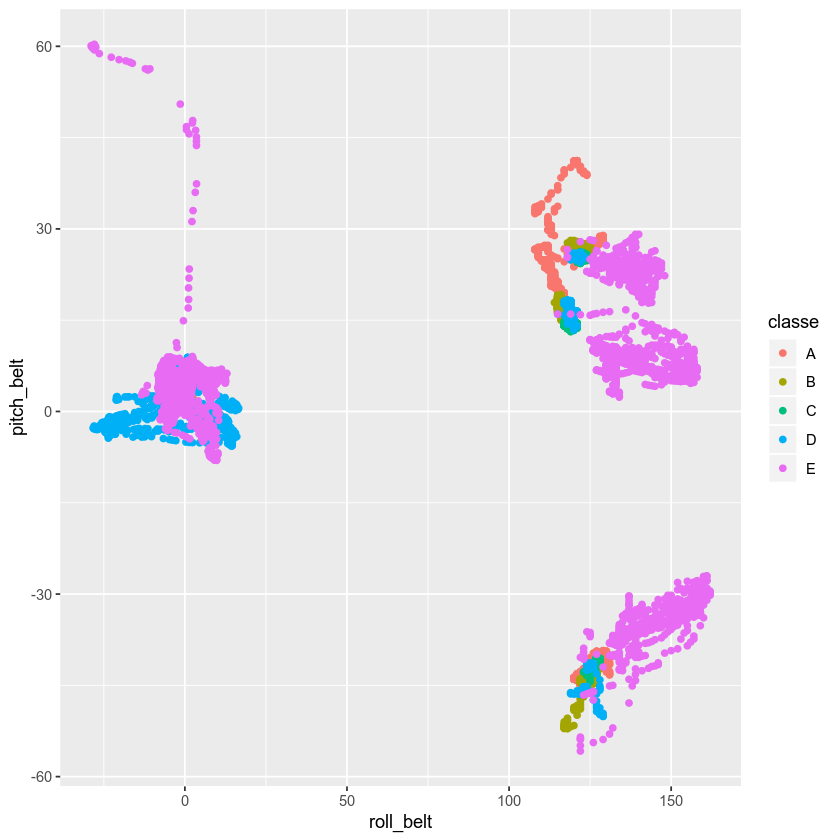

In [43]:
qplot(roll_belt, pitch_belt, color=classe, data=training)

## Making more observations 

Making a pair plot for only 4 parameters, we discover that our data points are somehow clusterred in different regions. Although different classes are not completely differntiated in the following plot, it suggests that there might be a chance that by adding more features we would be able to make accurate differentiations. 

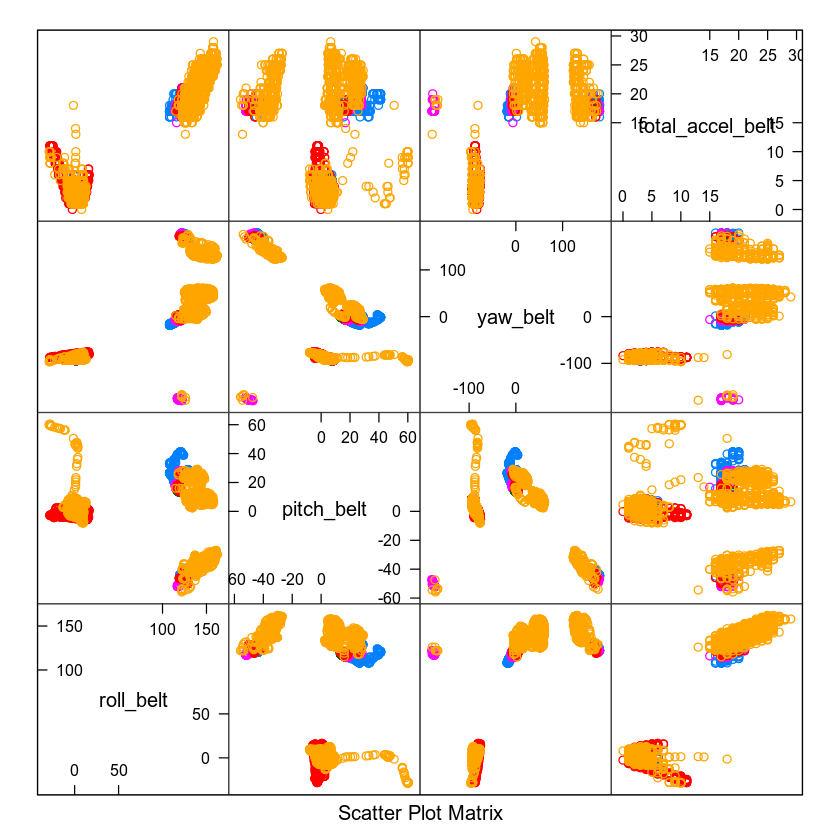

In [44]:
featurePlot(x=training[,c("roll_belt","pitch_belt","yaw_belt", "total_accel_belt")],
            y = training$classe,
            plot="pairs")

## Using Random Forest for prediction

In the following cell, we perform a random forest analysis to get our model. To begin with, we only use those parameters that are related to "belt" and ignore the otehrs to see if we are able to make good predictions.

To get better results, we do some standarization preprocessing. We also control our training process by setting trControl parameter. This allows the training algrotihm to set away 30% of the given training data for cross validation and tunes the internal parameters to reach the best accuracy after 5 iterations. 

In [19]:
set.seed(125)

RFmodel <- train(classe ~ roll_belt+pitch_belt+yaw_belt+total_accel_belt+
                gyros_belt_x+gyros_belt_y+gyros_belt_z+
                accel_belt_x+accel_belt_y+accel_belt_z+
                magnet_belt_x+magnet_belt_y+magnet_belt_z, 
                data = training, 
                method = "rf", 
                metric = "Accuracy", 
                preProcess = c("center", "scale"), 
                trControl = trainControl(method = "cv", 
                                       number = 5,           
                                       p = 0.7, 
                                       allowParallel = TRUE),                                       
                prox = TRUE)

Confusion Matrix and Statistics

          Reference
Prediction    A    B    C    D    E
         A 1571   24   39   28   12
         B   34 1049   41   13    2
         C   51   47  876   50    2
         D   56    8   20  876    4
         E   17    3    5    5 1052

Overall Statistics
                                          
               Accuracy : 0.9217          
                 95% CI : (0.9145, 0.9284)
    No Information Rate : 0.2938          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.9008          
                                          
 Mcnemar's Test P-Value : 0.001006        

Statistics by Class:

                     Class: A Class: B Class: C Class: D Class: E
Sensitivity            0.9086   0.9275   0.8930   0.9012   0.9813
Specificity            0.9752   0.9811   0.9694   0.9821   0.9938
Pos Pred Value         0.9385   0.9210   0.8538   0.9087   0.9723
Neg Pred Value         0.9625   0.982

## Checking the trained RF model for the trainign set

Here we use the resulting random forest to make predictions on the training set. As seen the accuracy is 100%, which means our model totally follows the shape of our data. We don't expect to get the same accuracy for the cross validation set.

In [38]:
rf.result.training <- predict(RFmodel, training)
confusionMatrix(training$classe, rf.result.training)

Confusion Matrix and Statistics

          Reference
Prediction    A    B    C    D    E
         A 3906    0    0    0    0
         B    0 2658    0    0    0
         C    0    0 2396    0    0
         D    0    0    0 2252    0
         E    0    0    0    0 2525

Overall Statistics
                                     
               Accuracy : 1          
                 95% CI : (0.9997, 1)
    No Information Rate : 0.2843     
    P-Value [Acc > NIR] : < 2.2e-16  
                                     
                  Kappa : 1          
                                     
 Mcnemar's Test P-Value : NA         

Statistics by Class:

                     Class: A Class: B Class: C Class: D Class: E
Sensitivity            1.0000   1.0000   1.0000   1.0000   1.0000
Specificity            1.0000   1.0000   1.0000   1.0000   1.0000
Pos Pred Value         1.0000   1.0000   1.0000   1.0000   1.0000
Neg Pred Value         1.0000   1.0000   1.0000   1.0000   1.0000
Prevalence      

## Evaluating the trained RF model for the Cross Validation Set

As expected the performance of our model is worse (~98%) on the cross validation set. Also, 98% is still a good accuracy. This means that only using the data from the belt sensors would be enough to get good predictions. 

In [45]:
rf.result <- predict(RFmodel, crossvalidation)
confusionMatrix(crossvalidation$classe, rf.result)

Confusion Matrix and Statistics

          Reference
Prediction    A    B    C    D    E
         A 1647    8   11    5    3
         B    6 1120   10    3    0
         C   14   11  985   15    1
         D   17    1    3  942    1
         E    8    1    0    0 1073

Overall Statistics
                                         
               Accuracy : 0.9799         
                 95% CI : (0.976, 0.9834)
    No Information Rate : 0.2875         
    P-Value [Acc > NIR] : <2e-16         
                                         
                  Kappa : 0.9746         
                                         
 Mcnemar's Test P-Value : 0.0178         

Statistics by Class:

                     Class: A Class: B Class: C Class: D Class: E
Sensitivity            0.9734   0.9816   0.9762   0.9762   0.9954
Specificity            0.9936   0.9960   0.9916   0.9955   0.9981
Pos Pred Value         0.9839   0.9833   0.9600   0.9772   0.9917
Neg Pred Value         0.9893   0.9956   0.995

## Make predictions using the Test set

The followig cell takes the test set and uses the same trained RF model to predict the class of each row. 

In [48]:
rf.result.Testing <- predict(RFmodel, Testing)
for (i in Testing$problem_id) {
cat(sprintf("Quiz #%d \t \"%s\"\n", Testing$problem_id[i], rf.result.Testing[i]))
}

Quiz #1 	 "B"
Quiz #2 	 "A"
Quiz #3 	 "B"
Quiz #4 	 "A"
Quiz #5 	 "A"
Quiz #6 	 "E"
Quiz #7 	 "D"
Quiz #8 	 "B"
Quiz #9 	 "A"
Quiz #10 	 "A"
Quiz #11 	 "B"
Quiz #12 	 "C"
Quiz #13 	 "B"
Quiz #14 	 "A"
Quiz #15 	 "E"
Quiz #16 	 "E"
Quiz #17 	 "A"
Quiz #18 	 "B"
Quiz #19 	 "B"
Quiz #20 	 "B"


## Training a more complicated Random Forest using all data features

To even get better results, we train a more complex random forest model that uses all data columns. This part take more computation resources.

In [21]:
set.seed(125)

RFmodel.all <- train(classe ~ new_window+num_window+ 
                roll_belt+pitch_belt+yaw_belt+total_accel_belt+
                gyros_belt_x+gyros_belt_y+gyros_belt_z+
                accel_belt_x+accel_belt_y+accel_belt_z+
                magnet_belt_x+magnet_belt_y+magnet_belt_z+
                roll_arm+pitch_arm+yaw_arm+total_accel_arm+
                gyros_arm_x+gyros_arm_y+gyros_arm_z+
                accel_arm_x+accel_arm_y+accel_arm_z+
                magnet_arm_x+magnet_arm_y+magnet_arm_z+
                roll_dumbbell+pitch_dumbbell+yaw_dumbbell+total_accel_dumbbell+
                gyros_dumbbell_x+gyros_dumbbell_y+gyros_dumbbell_z+
                accel_dumbbell_x+accel_dumbbell_y+accel_dumbbell_z+
                magnet_dumbbell_x+magnet_dumbbell_x+magnet_dumbbell_z+
                roll_forearm+pitch_forearm+yaw_forearm+total_accel_forearm+
                gyros_forearm_x+gyros_forearm_y+gyros_forearm_z+
                accel_forearm_x+accel_forearm_y+accel_forearm_z+
                magnet_forearm_x+magnet_forearm_y+magnet_forearm_z, 
                data = training, 
                method = "rf", 
                metric = "Accuracy", 
                preProcess = c("center", "scale"), 
                trControl = trainControl(method = "cv", 
                                       number = 5,           
                                       p = 0.7, 
                                       allowParallel = TRUE),                                       
                prox = TRUE)

Confusion Matrix and Statistics

          Reference
Prediction    A    B    C    D    E
         A 1672    2    0    0    0
         B    0 1139    0    0    0
         C    0    1 1025    0    0
         D    0    0    1  963    0
         E    0    0    0    3 1079

Overall Statistics
                                          
               Accuracy : 0.9988          
                 95% CI : (0.9976, 0.9995)
    No Information Rate : 0.2841          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.9985          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: A Class: B Class: C Class: D Class: E
Sensitivity            1.0000   0.9974   0.9990   0.9969   1.0000
Specificity            0.9995   1.0000   0.9998   0.9998   0.9994
Pos Pred Value         0.9988   1.0000   0.9990   0.9990   0.9972
Neg Pred Value         1.0000   0.999

## Evaluating the perforamnce of the RF-all on the training set

Like the other model, the accuracy is 100%. Now the question is whether we get better results on the cross validation set.

In [37]:
rf.result.training <- predict(RFmodel.all, training)
confusionMatrix(training$classe, rf.result.training)

Confusion Matrix and Statistics

          Reference
Prediction    A    B    C    D    E
         A 3906    0    0    0    0
         B    0 2658    0    0    0
         C    0    0 2396    0    0
         D    0    0    0 2252    0
         E    0    0    0    0 2525

Overall Statistics
                                     
               Accuracy : 1          
                 95% CI : (0.9997, 1)
    No Information Rate : 0.2843     
    P-Value [Acc > NIR] : < 2.2e-16  
                                     
                  Kappa : 1          
                                     
 Mcnemar's Test P-Value : NA         

Statistics by Class:

                     Class: A Class: B Class: C Class: D Class: E
Sensitivity            1.0000   1.0000   1.0000   1.0000   1.0000
Specificity            1.0000   1.0000   1.0000   1.0000   1.0000
Pos Pred Value         1.0000   1.0000   1.0000   1.0000   1.0000
Neg Pred Value         1.0000   1.0000   1.0000   1.0000   1.0000
Prevalence      

## Evaluating RFmodel.all on the cross-validation set

This time, the accouracy is ~99.9% which is of course better than 98% we got using the our first Random Forest model. Our conclusion is that adding more features definitely improves our prediction accuracy. 

This means that for improving accuracy by 2%, we needed to use all ifnroamtion from all sensors. Sometimes adding more sensors is expensive and is not worth the few percent improvment in predictions.

In [35]:
rf.result.all <- predict(RFmodel.all, crossvalidation)
confusionMatrix(crossvalidation$classe, rf.result.all)

Confusion Matrix and Statistics

          Reference
Prediction    A    B    C    D    E
         A 1672    2    0    0    0
         B    0 1139    0    0    0
         C    0    1 1025    0    0
         D    0    0    1  963    0
         E    0    0    0    3 1079

Overall Statistics
                                          
               Accuracy : 0.9988          
                 95% CI : (0.9976, 0.9995)
    No Information Rate : 0.2841          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.9985          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: A Class: B Class: C Class: D Class: E
Sensitivity            1.0000   0.9974   0.9990   0.9969   1.0000
Specificity            0.9995   1.0000   0.9998   0.9998   0.9994
Pos Pred Value         0.9988   1.0000   0.9990   0.9990   0.9972
Neg Pred Value         1.0000   0.999

## Using RFmodel.all to make predictions on the Test set

In [46]:
rf.result.Testing <- predict(modFit.all, Testing)
for (i in Testing$problem_id) {
cat(sprintf("Quiz #%d \t \"%s\"\n", Testing$problem_id[i], rf.result.Testing[i]))
}

Quiz #1 	 "B"
Quiz #2 	 "A"
Quiz #3 	 "B"
Quiz #4 	 "A"
Quiz #5 	 "A"
Quiz #6 	 "E"
Quiz #7 	 "D"
Quiz #8 	 "B"
Quiz #9 	 "A"
Quiz #10 	 "A"
Quiz #11 	 "B"
Quiz #12 	 "C"
Quiz #13 	 "B"
Quiz #14 	 "A"
Quiz #15 	 "E"
Quiz #16 	 "E"
Quiz #17 	 "A"
Quiz #18 	 "B"
Quiz #19 	 "B"
Quiz #20 	 "B"


# Further Investigations 

## The possible use of PCA in this analysis

Please stop here if you are grading this asssignment. This is just for my further curiosity.
   
So far, we have used 54 useful features to make a perfect prediction model.
Below, I am trying to make a compression and see how many PCA I can generate to hold 95% of the scatter in the data.

In [14]:
features = c("classe", 
                "new_window","num_window", 
                "roll_belt","pitch_belt","yaw_belt","total_accel_belt",
                "gyros_belt_x","gyros_belt_y","gyros_belt_z",
                "accel_belt_x","accel_belt_y","accel_belt_z",
                "magnet_belt_x","magnet_belt_y","magnet_belt_z",
                "roll_arm","pitch_arm","yaw_arm","total_accel_arm",
                "gyros_arm_x","gyros_arm_y","gyros_arm_z",
                "accel_arm_x","accel_arm_y","accel_arm_z",
                "magnet_arm_x","magnet_arm_y","magnet_arm_z",
                "roll_dumbbell","pitch_dumbbell","yaw_dumbbell","total_accel_dumbbell",
                "gyros_dumbbell_x","gyros_dumbbell_y","gyros_dumbbell_z",
                "accel_dumbbell_x","accel_dumbbell_y","accel_dumbbell_z",
                "magnet_dumbbell_x","magnet_dumbbell_x","magnet_dumbbell_z",
                "roll_forearm","pitch_forearm","yaw_forearm","total_accel_forearm",
                "gyros_forearm_x","gyros_forearm_y","gyros_forearm_z",
                "accel_forearm_x","accel_forearm_y","accel_forearm_z",
                "magnet_forearm_x","magnet_forearm_y","magnet_forearm_z")


training <- training[names(training) %in% features]
crossvalidation <- crossvalidation[names(crossvalidation) %in% features]
Testing <- Testing[names(Testing) %in% features]

head(training)

,new_window,num_window,roll_belt,pitch_belt,yaw_belt,total_accel_belt,gyros_belt_x,gyros_belt_y,gyros_belt_z,accel_belt_x,⋯,gyros_forearm_x,gyros_forearm_y,gyros_forearm_z,accel_forearm_x,accel_forearm_y,accel_forearm_z,magnet_forearm_x,magnet_forearm_y,magnet_forearm_z,classe
,<fct>,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>,⋯,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<fct>
1,no,11,1.41,8.07,-94.4,3,0.00,0.00,-0.02,-21,⋯,0.03,0.00,-0.02,192,203,-215,-17,654,476,A
3,no,11,1.42,8.07,-94.4,3,0.00,0.00,-0.02,-20,⋯,0.03,-0.02,0.00,196,204,-213,-18,658,469,A
5,no,12,1.48,8.07,-94.4,3,0.02,0.02,-0.02,-21,⋯,0.02,0.00,-0.02,189,206,-214,-17,655,473,A
7,no,12,1.42,8.09,-94.4,3,0.02,0.00,-0.02,-22,⋯,0.02,0.00,-0.02,195,205,-215,-18,659,470,A
8,no,12,1.42,8.13,-94.4,3,0.02,0.00,-0.02,-22,⋯,0.02,-0.02,0.00,193,205,-213,-9,660,474,A
9,no,12,1.43,8.16,-94.4,3,0.02,0.00,-0.02,-20,⋯,0.03,0.00,-0.02,193,204,-214,-16,653,476,A


,new_window,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,⋯,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,no,2.972763,3.686171,2.089551,1.540422,-1.512766,1.792066,0.01717150,-2.777324,0.2172460,⋯,-0.6437110,0.05970558,0.5677851,0.3438208,1.538746,-0.3820322,0.07106292,-0.3766739,-0.3737574,0.1949081
3,no,2.968619,3.711323,2.092228,1.541832,-1.519221,1.795919,-0.01006257,-2.755328,0.2517540,⋯,-0.6629756,0.09638254,0.5759817,0.3332674,1.541581,-0.3577407,0.06750221,-0.3704316,-0.3509060,0.1900447
5,no,2.944507,3.756857,2.052044,1.517674,-1.545017,1.885336,-0.05838001,-2.721783,0.2323673,⋯,-0.6123764,0.13444709,0.5911024,0.3136318,1.537784,-0.3912644,0.02233997,-0.3842049,-0.3486524,0.2191613
7,no,2.978695,3.685720,2.068711,1.531830,-1.520426,1.809691,-0.03159538,-2.767830,0.2414495,⋯,-0.6395848,0.07284003,0.5387824,0.3412634,1.516248,-0.3886653,0.04780037,-0.3882825,-0.3607784,0.2016864
8,no,2.966336,3.711241,2.083815,1.544567,-1.547465,1.831619,-0.02977678,-2.774799,0.2402008,⋯,-0.6483164,0.09504551,0.5489882,0.3359293,1.519738,-0.3712759,0.03583650,-0.3683829,-0.3626895,0.2304104
9,no,2.982772,3.734518,2.068318,1.524030,-1.504500,1.799560,-0.00608277,-2.735300,0.2499761,⋯,-0.6614894,0.08114417,0.5539319,0.3394942,1.535773,-0.3469845,0.06319026,-0.3839697,-0.3230635,0.1930678


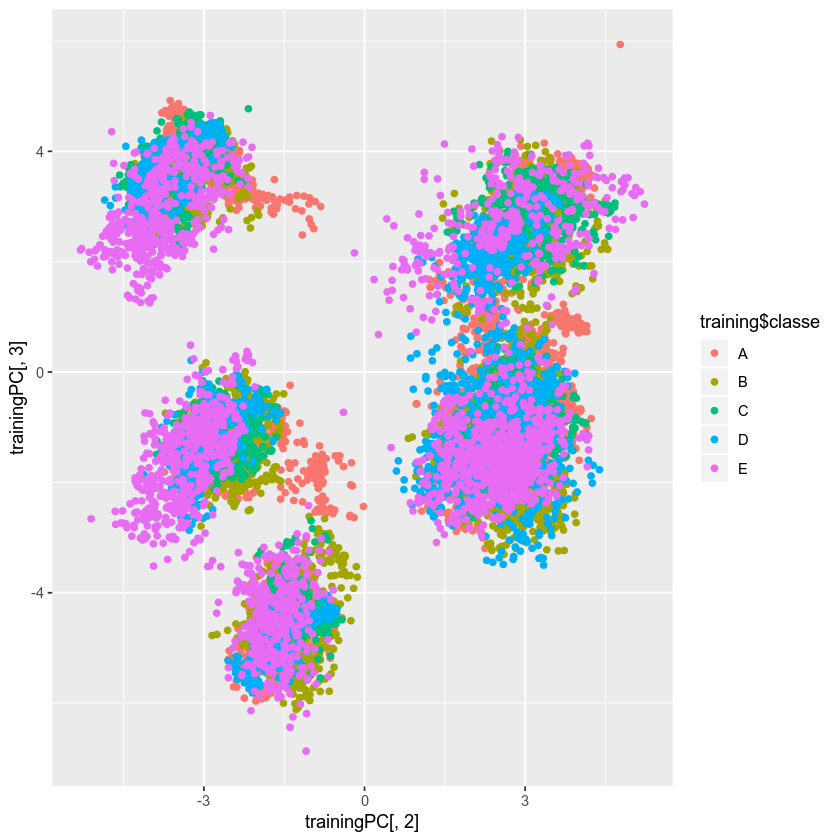

In [16]:
## I only require 95% of the scatter
## and I end up with 25 PCAs. This means that training a Random Forest with these PCA features
## could be possibly faster and produce the same accuracy

preProc <- preProcess(training[,-54], method=c('center', 'scale', 'pca'), thresh=0.95)

trainingPC <- predict(preProc,training[,-54])
head(trainingPC)
qplot(trainingPC[,2], trainingPC[,3], color=training$classe)

In [ ]:
## This part needs some modifications

set.seed(125)

modFit.all <- train(training$classe ~ ., 
                method = "rf", 
                metric = "Accuracy", 
                preProcess = c("center", "scale"), 
                trControl = trainControl(method = "cv", 
                                       number = 5,           
                                       p = 0.7, 
                                       allowParallel = TRUE),   
                data = trainingPC, 
                prox = TRUE)

In [ ]:
crossvalidationPC <- predict(preProc,crossvalidation[,-54])
rf.result.all <- predict(modFit.all, crossvalidationPC)
confusionMatrix(crossvalidation$classe, rf.result.all)